In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

'c:\\Users\\jaesc2\\GitHub\\skforecast'

In [2]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import backtesting_forecaster, TimeSeriesFold
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import time
from lightgbm import LGBMRegressor
import seaborn as sns

In [3]:
# Descarga de data
# ==============================================================================
url = (
    'https://raw.githubusercontent.com/skforecast/skforecast-datasets/refs/heads/main/data/vic_electricity.csv'
)
data = pd.read_csv(url, sep=',')
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%dT%H:%M:%SZ')
data = data.set_index('Time')
data = data.asfreq('30min')
data = data.sort_index()
data = data.drop(columns='Date')
data = data.resample(rule='H', closed='left', label ='right').mean()
len(data)

C:\Users\jaesc2\AppData\Local\Temp\ipykernel_40276\1853947156.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = data.resample(rule='H', closed='left', label ='right').mean()


26304

In [4]:
# Backtesting forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 24 
             )

In [ ]:
refits = [7, 14, 30]
refits = [False, True] + refits
results = []
metrics = []

for refit in refits:

    cv = TimeSeriesFold(
        steps=24,
        initial_train_size=17482,
        fixed_train_size=False,
        refit=refit,
        verbose=False
    )

    tic = time.perf_counter()

    metric, predictions = backtesting_forecaster(
                            forecaster    = forecaster,
                            y             = data['Demand'],
                            cv            = cv,
                            metric        = 'mean_absolute_error',
                            verbose       = False,
                            show_progress = False
                        )

    toc = time.perf_counter()

    results.append(toc - tic)
    metrics.append(metric)

results = pd.DataFrame(
              data = {'refit value': refits, 
                      'execution time (s)': results, 
                      'metric': metrics},
          )

results = results.sort_values(by=['execution time (s)'])
results

╭──────────────────────────────── LongTrainingWarning ─────────────────────────────────╮
│ The forecaster will be fit 368 times. This can take substantial amounts of time. If  │
│ not feasible, try with `refit = False`.                                              │
│                                                                                      │
│                                                                                      │
│ Category : LongTrainingWarning                                                       │
│ Location :                                                                           │
│ c:\Users\jaesc2\GitHub\skforecast\skforecast\model_selection\_validation.py:240      │
│ Suppress : warnings.simplefilter('ignore', category=LongTrainingWarning)             │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────── LongTrainingWarning ─────────────────────────────────╮
│ The forecaster will be fit 52 times. This can take substantial amounts of time. If   │
│ not feasible, try with `refit = False`.                                              │
│                                                                                      │
│                                                                                      │
│ Category : LongTrainingWarning                                                       │
│ Location :                                                                           │
│ c:\Users\jaesc2\GitHub\skforecast\skforecast\model_selection\_validation.py:240      │
│ Suppress : warnings.simplefilter('ignore', category=LongTrainingWarning)             │
╰──────────────────────────────────────────────────────────────────────────────────────╯

KeyError: 'seconds'

In [6]:
results = results.sort_values(by=['execution time (s)'])
results

refit value  execution time (s)  \
4          30            8.839183   
3          14           12.318892   
0       False           15.000322   
2           7           16.615812   
1        True           83.089239   

                                          metric  
4     mean_absolute_error
0           263.428653  
3     mean_absolute_error
0           262.528465  
0     mean_absolute_error
0           262.509329  
2     mean_absolute_error
0           261.350947  
1     mean_absolute_error
0           258.736184

In [ ]:
print(results.to_markdown())

|    |   refit_value |   seconds |   metric |
|---:|--------------:|----------:|---------:|
|  0 |         False |   1.35568 |  262.509 |
|  4 |            30 |   3.99507 |  263.429 |
|  3 |            14 |   6.33748 |  262.528 |
|  2 |             7 |  11.0809  |  261.351 |
|  1 |          True |  69.1455  |  258.736 |


matplotlib.legend WARNING No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


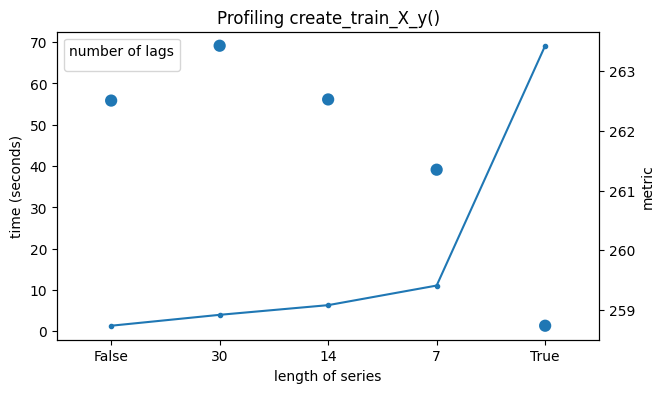

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(results['refit_value'].astype(str).to_numpy(), results['seconds'], marker='.')
ax2 = ax.twinx()
sns.pointplot(x=results['refit_value'].astype(str).to_numpy(), y=results['metric'], 
              join=False, ax=ax2)
# ax2.plot(results['refit_value'].astype(str).to_numpy(), results['metric'], marker='.')

ax.set_xlabel('length of series')
ax.set_ylabel('time (seconds)')
ax.set_title('Profiling create_train_X_y()')
ax.legend(title='number of lags');